In [1]:
import yfinance as yf
import pandas as pd
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from deepdow.data import InRAMDataset, RigidDataLoader
from deepdow.layers import SoftmaxAllocator
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
#from deepdow.layers import ConvNetwork
from deepdow.experiments import Run
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.benchmarks import OneOverN, InverseVolatility, Random, MinimumVariance
from deepdow.callbacks import EarlyStoppingCallback
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from deepdow.utils import raw_to_Xy
from deepdow.benchmarks import Benchmark, OneOverN, Random, MaximumReturn
from deepdow.experiments import Run
from deepdow.callbacks import EarlyStoppingCallback, ModelCheckpointCallback, Callback

In [2]:
#load data from parquet file
df = pd.read_parquet('mag7.parquet')
df.columns = df.columns.swaplevel(0,1)
raw_data = df.sort_index(axis=1)

In [8]:
raw_data.to_parquet('mag7_ticker_first.parquet', index=True)


In [9]:
df_read = pd.read_parquet('mag7_ticker_first.parquet')

In [27]:
df_read.xs('Close', level='Price', axis=1)

Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2006-03-27,1.788524,1.762500,9.207481,NaN,18.963913,0.407683,NaN
2006-03-28,1.764482,1.784500,9.394524,NaN,18.886673,0.413950,NaN
2006-03-29,1.873277,1.816000,9.837353,NaN,18.970926,0.436187,NaN
2006-03-30,1.885901,1.833500,9.674467,NaN,19.118364,0.439167,NaN
2006-03-31,1.884999,1.826500,9.713322,NaN,19.104324,0.437563,NaN
...,...,...,...,...,...,...,...
2025-03-20,213.819611,194.949997,162.800003,586.000000,386.131104,118.529999,236.259995
2025-03-21,217.984146,196.210007,163.990005,596.250000,390.543030,117.699997,248.710007
2025-03-24,220.440918,203.259995,167.679993,618.849976,392.359680,121.410004,278.390015


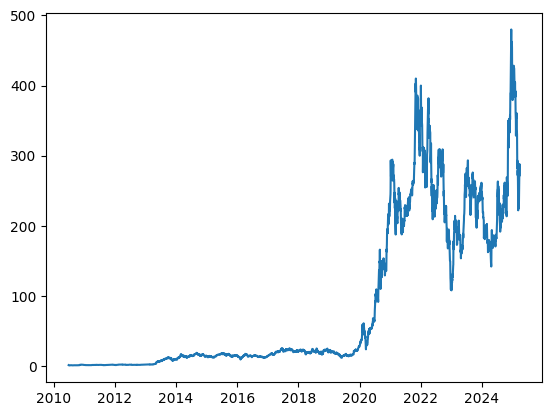

In [3]:
plt.plot(raw_data.index, raw_data['TSLA', 'Close'])

In [4]:
index = pd.date_range(
    start=raw_data.index[0], end=raw_data.index[-1], freq='B'
)
#new = pd.DataFrame(raw_data, index=index).ffill().bfill()
new = pd.DataFrame(raw_data, index=index)

In [16]:
#print NaN values of new['AAPL', 'Close']
print(new['AAPL', 'Close'][new['AAPL', 'Close'].isnull()])



2006-04-14   NaN
2006-05-29   NaN
2006-07-04   NaN
2006-09-04   NaN
2006-11-23   NaN
              ..
2024-12-25   NaN
2025-01-01   NaN
2025-01-09   NaN
2025-01-20   NaN
2025-02-17   NaN
Name: (AAPL, Close), Length: 177, dtype: float64


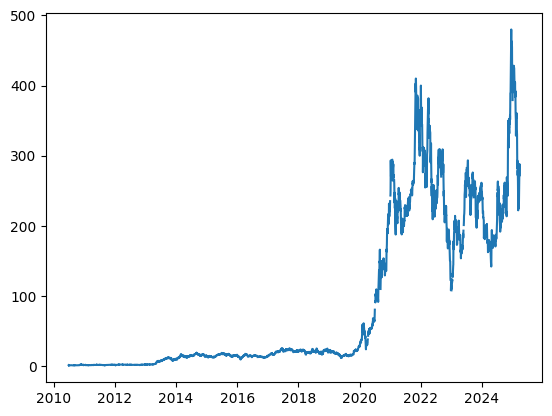

In [17]:
plt.plot(new.index, new['TSLA', 'Close'])

In [18]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA"]  # Mag7
lookback = 20
n_assets = len(tickers)
n_channels = 1
batch_size = 16
horizon = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
from matplotlib import axis
from pandas import DataFrame

new = new[tickers]
def get_stock_data(df , start="2017-01-01", end="2025-05-18"):

    # copy df data to a new DataFrame
    df = df.copy()
    df.columns = df.columns.swaplevel(0, 1)
    returns = df["Close"].pct_change() #.dropna()
    df.columns = df.columns.swaplevel(0, 1)
    # drop first row of dataframe
    df = df.iloc[1:-1]
    returns = returns.iloc[1:-1]
    return df, returns

def format_to_text(data, ticker):
    texts = []
    for date, row in data.iterrows():
        text = f"{date.strftime('%Y-%m-%d')} {ticker} 开盘价是 {row['Open']:.2f}，收盘价是 {row['Close']:.2f}，成交量是 {row['Volume']:.0f}"
        texts.append(text)
    return texts

data, returns = get_stock_data(new)
text_data = {ticker: format_to_text(data[ticker], ticker) for ticker in tickers}
timestamps = data.index.tolist()

/tmp/ipykernel_3314692/3338313867.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df["Close"].pct_change() #.dropna()


In [24]:
print(returns['AAPL'][0:10])  # Print first 5 entries for TSLA

2006-03-28   -0.013443
2006-03-29    0.061659
2006-03-30    0.006739
2006-03-31   -0.000478
2006-04-03   -0.001116
2006-04-04   -0.023623
2006-04-05    0.098741
2006-04-06    0.059961
2006-04-07   -0.020354
2006-04-10   -0.016048
Freq: B, Name: AAPL, dtype: float64


In [22]:
returns

Ticker,AAPL,MSFT,GOOGL,AMZN,NVDA,META,TSLA
2006-03-28,-0.013443,-0.004073,0.020314,0.012482,0.015372,NaN,NaN
2006-03-29,0.061659,0.004461,0.047137,0.017652,0.053720,NaN,NaN
2006-03-30,0.006739,0.007772,-0.016558,0.009637,0.006833,NaN,NaN
2006-03-31,-0.000478,-0.000734,0.004016,-0.003818,-0.003654,NaN,NaN
2006-04-03,-0.001116,0.012863,-0.000769,-0.010676,0.011176,NaN,NaN
...,...,...,...,...,...,...,...
2025-03-19,0.011989,0.011212,0.020041,0.014106,0.018106,0.002919,0.046824
2025-03-20,-0.005296,-0.002527,-0.006651,-0.003017,0.008594,0.003322,0.001696
2025-03-21,0.019477,0.011426,0.007310,0.006463,-0.007002,0.017491,0.052696
2025-03-24,0.011270,0.004652,0.022501,0.035931,0.031521,0.037904,0.119336


In [9]:
# 步骤 2：使用 Qwen2 0.5B 提取隐藏层特征
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-0.6B")
llm_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen3-0.6B").to(device)
llm_model.eval()

def extract_hidden_features(texts, max_length=128):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
    with torch.no_grad():
        outputs = llm_model(**inputs, output_hidden_states=True)
    last_hidden_state = outputs.hidden_states[-1] #len(hidden_states))          # 层数 + 1（包含 embedding 层）
    return last_hidden_state #outputs.last_hidden_state[:, 0, :]

features = []
for ticker in tickers:
    ticker_texts = text_data[ticker]
    batch_texts = [ticker_texts[i:i+batch_size] for i in range(0, len(ticker_texts), batch_size)]
    ticker_features = []
    for batch in batch_texts:
        batch_features = extract_hidden_features(batch)
        #add meanpool
        batch_features = torch.mean(batch_features, dim=1)
        ticker_features.append(batch_features)
    ticker_features = torch.cat(ticker_features, dim=0)
    features.append(ticker_features)

features = torch.stack(features, dim=-1)  # (n_timesteps, hidden_size, n_assets)

In [8]:
#save features, returns, timestamps to file using numpy format
np.savez('dataset/features_returns_timestamps.npz', features=features.cpu().numpy(), returns=returns, timestamps=timestamps)

In [10]:
#load features, returns, timestamps from file
loaded_data = np.load('dataset/features_returns_timestamps.npz', allow_pickle=True)
loaded_features = loaded_data['features']
loaded_returns = loaded_data['returns']
loaded_timestamps = loaded_data['timestamps'].tolist()

In [17]:
loaded_features.shape

(4956, 1024, 7)

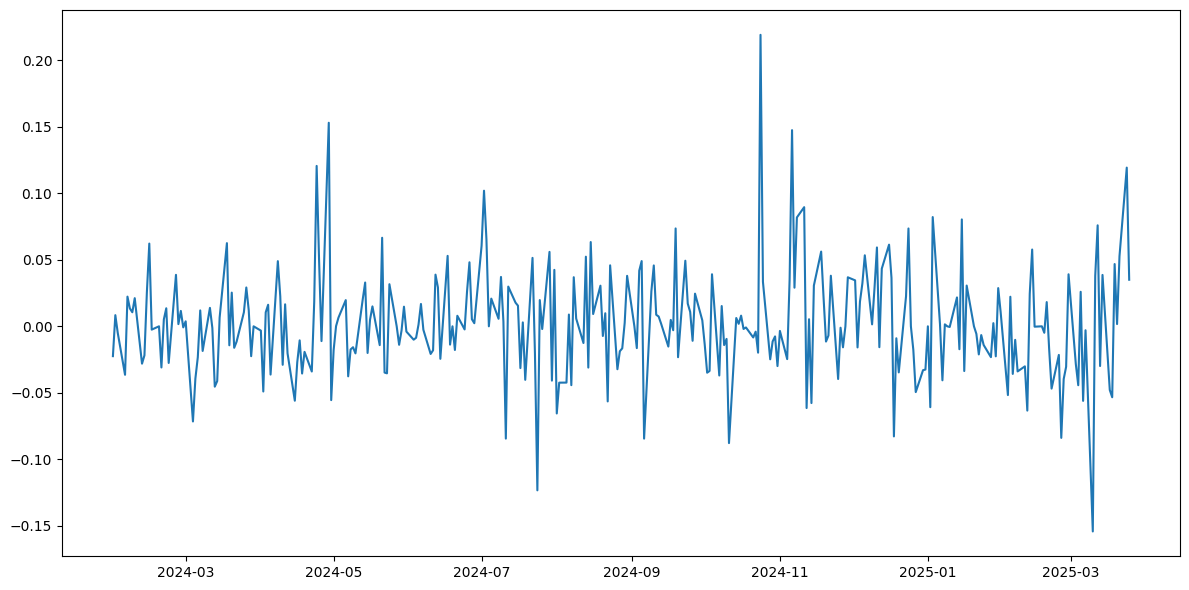

In [27]:
#plot timestamps and loaded_timestamps in a single plot
plt.figure(figsize=(12, 6))
plt.plot(loaded_timestamps[-300:], loaded_returns[-300:,6])
#plt.plot(timestamps, returns, label='Returns2', color='red')

plt.tight_layout()
plt.show()

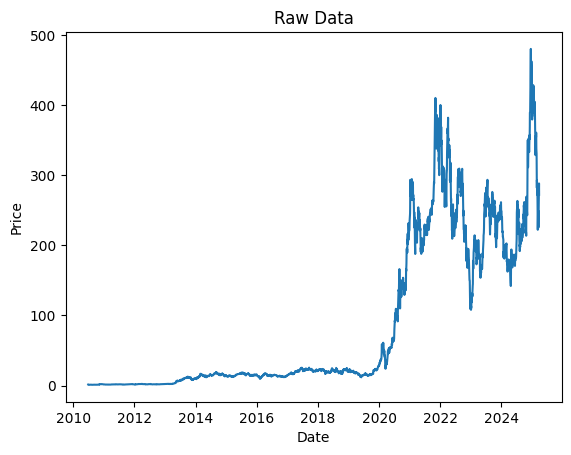

In [26]:
# plot the raw_data
plt.plot(raw_data.index, raw_data['TSLA','Close'], label='TSLA')
plt.title("Raw Data")
plt.xlabel("Date")
plt.ylabel("Price")

plt.show()

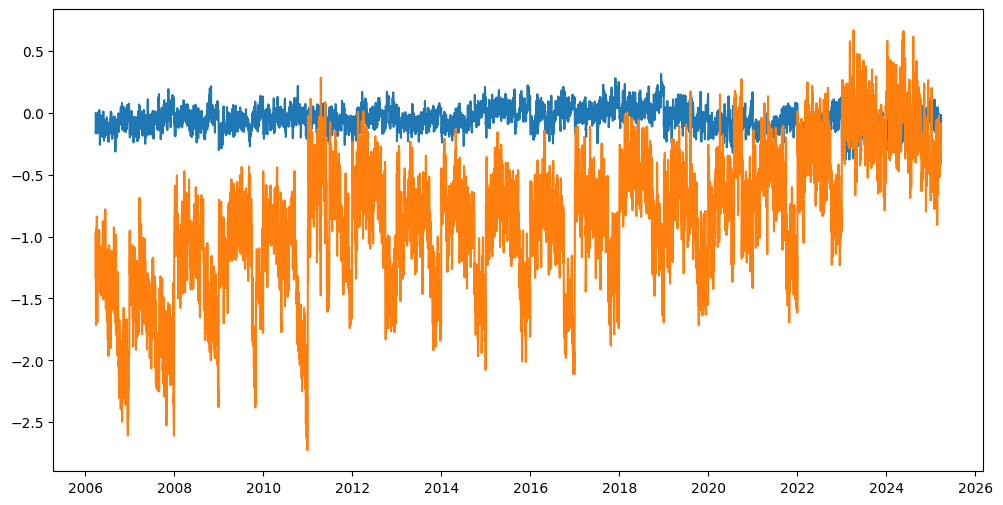

In [7]:
#plot the features
plt.figure(figsize=(12, 6))
plt.plot(timestamps, features[:, 0:2, 0], label='AAPL Features')